# ¿Cómo te sientes? - Parte II
Resources: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

En la primera parte vimos que es una convolución y entendimos visualmente como se representan las características extraídas con cada tipo de filtro. Ahora nos toca usar esas características para algo útil. Por ejemplo: detectar que emoción muestra una persona en una fotografía de su rostro.

## Recoleccion de datos
Debemos crear un dataset balanceado y apto para el entremiento con una red neuronal convolucional. El conjunto de datos que utilizaremos proviene de Kaggle y contiene imágenes de rostros etiquetadas con diversas emociones. Es crucial comprobar que haya un conjunto equilibrado de instancias de cada clase a predecir en el dataset, para evitar sesgos que puedan afectar negativamente a la generalización de nuestro modelo. Por lo tanto, el primer paso será cargar y equilibrar los datos para asegurar que cada emoción esté igualmente representada.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd 
import json
import os
import tensorflow as tf

# Deshabilitar GPUs para TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-03-24 03:36:56.389547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 03:36:56.429607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 03:36:56.430482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 03:36:57.150060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def generate_dataset():
    """
    Genera DataFrames para los conjuntos de entrenamiento, validación y prueba.

    Returns:
    - Tuple de DataFrames: Contiene los DataFrames para los conjuntos de entrenamiento, validación y prueba.
    """
    base_dir = '/home/jd/Documentos/CODIGO/Machine-Learning/tutorials/how-do-you-feel?/resources/images/train'
    emotions = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    data = []
    for emotion in emotions:
        emotion_dir = os.path.join(base_dir, emotion)
        for image in os.listdir(emotion_dir):
            if image.endswith('.jpg'):
                data.append((emotion, os.path.join(emotion_dir, image)))

    train, test_val = train_test_split(data, test_size=0.3, random_state=42)
    test, val = train_test_split(test_val, test_size=0.3, random_state=42)

    return (pd.DataFrame(data, columns=['Emotion', 'Path']) for data in [train, test, val])

In [3]:
def balance_df(df):
    """
    Balancea el DataFrame para tener la misma cantidad de muestras para cada emoción.

    Args:
    - df (DataFrame): DataFrame que contiene las emociones y las rutas de las imágenes.

    Returns:
    - DataFrame: DataFrame balanceado.
    """
    min_samples = df['Emotion'].value_counts().min()
    dfs = [df[df['Emotion'] == emotion].sample(n=min_samples, random_state=42) for emotion in df['Emotion'].unique()]
    return pd.concat(dfs, ignore_index=True)

In [4]:
train_df, test_df, val_df = generate_dataset()

In [5]:
train_df['Emotion'].value_counts()

Emotion
happy       4978
neutral     3517
sad         3400
fear        2892
angry       2783
surprise    2299
Name: count, dtype: int64

Después de dividir nuestro conjunto de datos en entrenamiento, validación y prueba, observamos un desequilibrio significativo entre las clases: tenemos 2299 instancias de 'suprise' y 4978 de 'happy'. Tal desequilibrio puede conducir a un modelo sesgado, por lo que el siguiente paso es balancear estos conjuntos. 

### Balanceo de datos

In [6]:
train_df = balance_df(train_df)
test_df  = balance_df(test_df)
val_df   = balance_df(val_df)
train_df['Emotion'].value_counts()

Emotion
sad         2299
happy       2299
neutral     2299
surprise    2299
fear        2299
angry       2299
Name: count, dtype: int64

## Data Preprocessing and Data Augmentation

Hemos preparado y balanceado los conjuntos de datos, el siguiente paso es implementar el preprocesamiento de las imágenes antes de alimentarlas a la CNN. Para ello, vamos a utilizar el módulo ImageDataGenerator de Keras. Este módulo permite generar y preprocesar imágenes de forma sencilla, dejándolas listas para el entrenamiento de nuestro modelo. Además, aplicaremos una técnica conocida como DataAugmentation.

El aumento de datos es una técnica usada para aumentar la diversidad de nuestro conjunto de datos sin necesidad de recopilar más datos. Consiste en introducir ruido a nuestro dataset. En el caso de imagenes este ruido son: rotaciones, desplazamientos, volteos, desenfoques, etc. Introduciendo este ruido conseguimos que  el modelo se vuelva más robusto y menos propenso al sobreajuste: que generalice mejor. 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale

datagen_config = dict(
    rescale=1./255,                                       # Normalización de las imágenes (dividir por 255)
    rotation_range=20,                                    # Rotaciones aleatorias de hasta 20 grados
    width_shift_range=0.2,                                # Desplazamientos horizontales
    height_shift_range=0.2,                               # Desplazamientos verticales
    shear_range=0.2,                                      # Cortes
    zoom_range=0.2,                                       # Zoom aleatorio
    horizontal_flip=True,                                 # Volteo horizontal para aumentar la variedad
    fill_mode='nearest',                                  # Rellenar los píxeles faltantes con el valor más cercano
)

Util, ¿verdad? Pues podemos guardar los parámetros del generador ImageDataGenerator en el disco para usarlo posteriormente

In [8]:
# config_path = 'data_gen_params.json'
# with open(config_path, 'w') as file:
#     json.dump(datagen_config, file)

# with open(config_path, 'r') as file:
#     loaded_config = json.load(file)

Para pasar nuestras imágenes por una red neuronal, es conveniente convertirlas a una escala de grises. Así nuestra red convolucional podrá detectar características de forma eficiente. Estamos aplicando filtros en forma de matrices para detectar patrones en la intensidad de los píxeles y así dibujar contornos, el color no es necesario.

Convertir las imágenes a escala de grises reduce la complejidad computacional y permite que el modelo se enfoque en las características estructurales de las imágenes. Al aplicar CNN la idea subyacente es encontrar aplicar filtros de patrones visuales sobre imágenes para detectar bordes y contornos de los elementos presentes.

In [9]:
datagen_config = dict(
    rescale=1./255,                                       # Normalización de las imágenes (dividir por 255)
    rotation_range=20,                                    # Rotaciones aleatorias de hasta 20 grados
    width_shift_range=0.2,                                # Desplazamientos horizontales
    height_shift_range=0.2,                               # Desplazamientos verticales
    shear_range=0.2,                                      # Cortes
    zoom_range=0.2,                                       # Zoom aleatorio
    horizontal_flip=True,                                 # Volteo horizontal para aumentar la variedad
    fill_mode='nearest',   
    preprocessing_function=lambda x: rgb_to_grayscale(x) # Rellenar los píxeles faltantes con el valor más cercano
)

# Crear un nuevo ImageDataGenerator con los parámetros cargados
seed = 1
data_gen = ImageDataGenerator(**datagen_config)
data_gen.fit(train_df, augment=True, seed=seed)

test_gen = ImageDataGenerator(rescale=1./255)
test_gen.fit(test_df, augment=True, seed=seed)

val_gen = ImageDataGenerator(rescale=1./255)
val_gen.fit(val_df, augment=True, seed=seed)

In [10]:
# Generadores para los conjuntos de datos
train_generator = data_gen.flow_from_dataframe(train_df, x_col='Path', y_col='Emotion', target_size=(48, 48), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(test_df, x_col='Path', y_col='Emotion', target_size=(48, 48), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(val_df, x_col='Path', y_col='Emotion', target_size=(48, 48), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)

Found 13794 validated image filenames belonging to 6 classes.
Found 3834 validated image filenames belonging to 6 classes.
Found 1602 validated image filenames belonging to 6 classes.


In [11]:
images, labels = next(train_generator)

In [12]:
images[0].shape

(48, 48, 3)

In [13]:
data_gen

## Arquitectura y entrenamiento del modelo

La arquitectura de nuestra CNN incluye varias capas convolucionales y de pooling, seguidas de capas densas para la clasificación. Cada capa convolucional aprenderá diferentes características de las imágenes, desde bordes simples en las primeras capas hasta patrones más complejos y específicos en las capas más profundas. El proceso de entrenamiento ajustará estos filtros para minimizar la pérdida, utilizando los datos de entrenamiento y validando el rendimiento con el conjunto de validación. Observaremos cómo evoluciona la precisión y la pérdida a lo largo de las épocas para comprender mejor el proceso de aprendizaje de nuestro modelo.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definición del modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanamiento y capa densa
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Dropout para reducir el sobreajuste
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(6, activation='softmax'))  # Suponiendo 7 emociones

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=15,  
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/15


2024-03-24 03:36:59.310055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


431/431 [==============================] - ETA: 0s - loss: 1.7884 - accuracy: 0.1822

2024-03-24 03:37:43.920059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


431/431 [==============================] - 46s 104ms/step - loss: 1.7884 - accuracy: 0.1822 - val_loss: 1.7683 - val_accuracy: 0.2281
Epoch 2/15
431/431 [==============================] - 43s 100ms/step - loss: 1.7692 - accuracy: 0.2096 - val_loss: 1.7258 - val_accuracy: 0.2631
Epoch 3/15
431/431 [==============================] - 54s 125ms/step - loss: 1.7462 - accuracy: 0.2350 - val_loss: 1.6909 - val_accuracy: 0.2837
Epoch 4/15
431/431 [==============================] - 42s 97ms/step - loss: 1.7303 - accuracy: 0.2473 - val_loss: 1.7007 - val_accuracy: 0.2569
Epoch 5/15
431/431 [==============================] - 38s 87ms/step - loss: 1.7098 - accuracy: 0.2621 - val_loss: 1.6373 - val_accuracy: 0.3056
Epoch 6/15
431/431 [==============================] - 37s 87ms/step - loss: 1.6883 - accuracy: 0.2721 - val_loss: 1.6395 - val_accuracy: 0.2975
Epoch 7/15
431/431 [==============================] - 37s 86ms/step - loss: 1.6623 - accuracy: 0.2876 - val_loss: 1.5880 - val_accuracy: 0.3363


## Evaluación del modelo

Evaluación en el conjunto de datos de prueba para medir su rendimiento en datos no vistos anteriormente. Es decir: es el primer examen real de nuestro modelo

In [16]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test accuracy:', test_acc)


  3/119 [..............................] - ETA: 2s - loss: 1.5380 - accuracy: 0.2604

2024-03-24 03:48:30.847347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


119/119 [==============================] - 3s 26ms/step - loss: 1.4072 - accuracy: 0.4393
Test accuracy: 0.43933823704719543


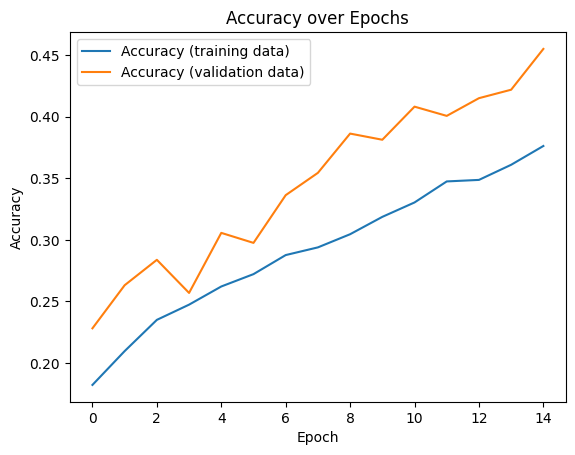

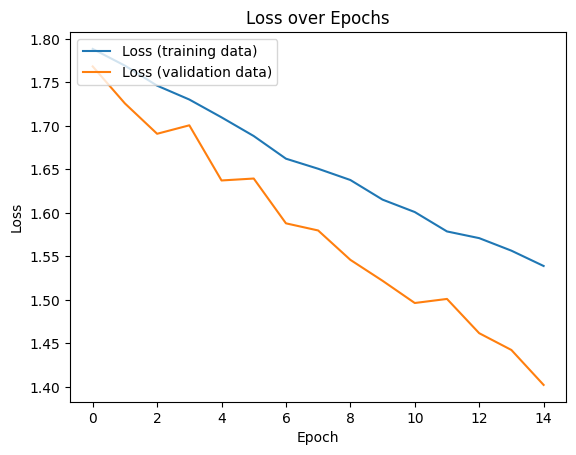

In [17]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definición del modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Cuarta capa convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanamiento y capa densa
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Dropout para reducir el sobreajuste
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(6, activation='softmax'))  # Suponiendo 7 emociones

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=15,  
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/15


2024-03-24 03:57:38.805707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


431/431 [==============================] - ETA: 0s - loss: 1.7926 - accuracy: 0.1699

2024-03-24 03:58:32.723864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


431/431 [==============================] - 55s 125ms/step - loss: 1.7926 - accuracy: 0.1699 - val_loss: 1.7938 - val_accuracy: 0.1669
Epoch 2/15
431/431 [==============================] - 55s 128ms/step - loss: 1.7884 - accuracy: 0.1819 - val_loss: 1.7760 - val_accuracy: 0.2231
Epoch 3/15
431/431 [==============================] - 59s 137ms/step - loss: 1.7784 - accuracy: 0.2110 - val_loss: 1.7572 - val_accuracy: 0.2231
Epoch 4/15
431/431 [==============================] - 59s 136ms/step - loss: 1.7431 - accuracy: 0.2392 - val_loss: 1.6977 - val_accuracy: 0.2531
Epoch 5/15
431/431 [==============================] - 46s 108ms/step - loss: 1.7214 - accuracy: 0.2493 - val_loss: 1.6451 - val_accuracy: 0.2950
Epoch 6/15
431/431 [==============================] - 45s 103ms/step - loss: 1.6916 - accuracy: 0.2652 - val_loss: 1.6267 - val_accuracy: 0.2950
Epoch 7/15
431/431 [==============================] - 47s 110ms/step - loss: 1.6642 - accuracy: 0.2857 - val_loss: 1.6173 - val_accuracy: 0.3

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test accuracy:', test_acc)

In [ ]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()
